# Called Third Strike
## Part 6. Improved non-neural network model

![](./resources/baseball_umpire_home_plate_1.jpg)

This project's goal is to build probability models for as to whether a pitch will be called a strike or not. The intended models are to be:
1. A neural network (NN) based approach.
2. A non-NN based approach.

---

__**This Notebook's**__ objective is to iterate on the work done with the [first attempts](04_first_crude_non_nn_model.ipynb) at a "classical" ML classication model. As with the ['improved' neural network model](05_improved_neural_network.ipynb), we will be adding in these other features:
- Included Handedness of both pitcher and batter; I hypothesize that this will have some signal with regards to the 'strike-ness' of the horizontal movement of the pitch. As for verticality, I think that the stringer data helps with that since it provides fairly concrete guardrails as to the strike-ness (assuming the umpire sees the same thing haha).
- Include pitch break and angle. I hypothesize this acts like a proxy to the pitcher, without having to rely on the pitcher_IDs. Rough analogy but I think of it kind of like latent factors in ALS matrix factorization (which I need to brush up on heh).

---
---

### Table of Contents<a id='toc'></a>

<a href='#data_prep'>1. Data Preprocessing</a>

~<a href='#build_model'>2. Build Model</a>~ Straight to Random Search!

<a href='#random_search'>3. Random Hyperparameter Search</a>

<a href='#summary'>4. Summary</a>

<a href='#tuning'>5. (Re-)Tuning</a>

<a href='#more_tuning'>6. More Tuning</a>

...

<a href='#the_end'>Go to the End</a>

---

---  

<span style="font-size:0.5em;">Tag 1</span>

### Data Preprocessing<a id='data_prep'></a>

<span style="font-size:0.5em;"><a href='#toc'>Back to TOC</a></span>


#### Libraries


In [136]:
# Data wrangling and operations
import pandas as pd
import numpy as np
from datetime import datetime, timezone
import pytz
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# try:
#     import plotly_express as pex
# except ImportError:
#     !pip install plotly_express
# except ModuleNotFoundError:
#     !pip install plotly_express

# Estimators
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import BaseEstimator

# Processing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Assessment
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, auc
from sklearn.metrics import roc_curve, RocCurveDisplay

---

#### Data Import 

Retrieve the latest version of our train/test files that we built during [initial exploration](02_data_exploration.ipynb).

In [137]:
df_train = pd.read_pickle('../data/train_enriched.pkl')
df_test = pd.read_pickle('../data/test_enriched.pkl')

Let's refamiliarize ourselves with the features.

In [138]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350959 entries, 0 to 354038
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   pitch_id              350959 non-null  object        
 1   inning                350959 non-null  int64         
 2   side                  350959 non-null  object        
 3   run_diff              350959 non-null  int64         
 4   at_bat_index          350959 non-null  int64         
 5   pitch_of_ab           350959 non-null  int64         
 6   batter                350959 non-null  int64         
 7   pitcher               350959 non-null  int64         
 8   catcher               350959 non-null  int64         
 9   umpire                350959 non-null  int64         
 10  bside                 350959 non-null  object        
 11  pside                 350959 non-null  object        
 12  stringer_zone_bottom  350959 non-null  float64       
 13 

---

#### Feature Selection and Prep, revisited

Select features:

For our initial super simple model, we had picked just four features: 
- `px` which is the horizontal location of the pitch at the plate
- `pz` which is the vertical location
- `stringer_zone_bottom` which is an estimate of current batter's strike zone bottom
- `stringer_zone_top` which is an estimate of current batter's strike zone top

In [139]:
# Features selected
feat_select = ['px', 'pz', 'stringer_zone_bottom', 'stringer_zone_top']

But as mentioned in the intro, I want to try adding `bside` and `pside`, as well as vertical/horizontal breaks and angles (`break_x`, `break_z`, `angle_x`, `angle_z`), and `pitch_speed`. 

##### Adding `break_x`, `break_z`, `angle_x`, `angle_z`, `pitch_speed`

These are numeric so I will add on to `feat_select`

In [140]:
feat_select = feat_select + ['break_x', 'break_z', 'angle_x', 'angle_z', 'pitch_speed']
feat_select = list(set(feat_select)) #Just to ensure no dupes if this cell gets executed again
display(feat_select)

['stringer_zone_top',
 'angle_x',
 'px',
 'pitch_speed',
 'pz',
 'break_x',
 'stringer_zone_bottom',
 'angle_z',
 'break_z']

##### Adding `b_side`, `p_side`

These are strings so I will one-hot encode them.

In [141]:
feat_cat_select = ['bside', 'pside']

In [142]:
df_train_cat_ohe = pd.get_dummies(df_train[feat_cat_select])

In [143]:
df_train_cat_ohe.head(3)

,bside_L,bside_R,pside_L,pside_R
0,0,1,1,0
1,1,0,0,1
2,1,0,1,0


In [144]:
df_train_cat_ohe.shape

(350959, 4)

Prep features:

Gather up all the selected features.

In [145]:
# Get just the selected features
df_X = pd.concat([df_train[feat_select], df_train_cat_ohe], axis=1)
# df_X = df_train_cat_ohe.copy()
display(df_X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350959 entries, 0 to 354038
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   stringer_zone_top     350959 non-null  float64
 1   angle_x               350959 non-null  float64
 2   px                    350959 non-null  float64
 3   pitch_speed           350959 non-null  float64
 4   pz                    350959 non-null  float64
 5   break_x               350959 non-null  float64
 6   stringer_zone_bottom  350959 non-null  float64
 7   angle_z               350959 non-null  float64
 8   break_z               350959 non-null  float64
 9   bside_L               350959 non-null  uint8  
 10  bside_R               350959 non-null  uint8  
 11  pside_L               350959 non-null  uint8  
 12  pside_R               350959 non-null  uint8  
dtypes: float64(9), uint8(4)
memory usage: 28.1 MB


None

In [146]:
df_X.head()

,stringer_zone_top,angle_x,px,pitch_speed,pz,break_x,stringer_zone_bottom,angle_z,break_z,bside_L,bside_R,pside_L,pside_R
0,3.41,3.02727,-1.298100,97.4298,2.302170,1.915350,1.56,5.59379,-9.54142,0,1,1,0
1,3.47,-1.56782,1.412220,91.7712,1.574430,-12.137300,1.59,6.86676,-21.94270,1,0,0,1
2,3.58,2.04966,-0.181190,87.8130,2.112480,-0.992261,1.68,7.17281,-25.51070,1,0,1,0
3,3.55,2.96845,-0.885538,86.5546,0.598692,-2.839300,1.63,8.50392,-27.25090,0,1,1,0
5,3.30,-1.64630,-1.459540,72.0904,3.399510,8.906150,1.50,9.33291,-59.41330,1,0,0,1


While we are at it, let's prep our targets:

In [147]:
df_y = df_train['strike_bool']
display(pd.DataFrame(df_y).info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350959 entries, 0 to 354038
Data columns (total 1 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   strike_bool  350959 non-null  int64
dtypes: int64(1)
memory usage: 5.4 MB


None

---

#### Feature Engineering

Select features:

For a neural network we will need to numerically represent our data (e.g. one-hot-encode any categorical features), as well as scale/normalize the data. 

All the selected features for this round are numerical, so we don't have to worry about encoding any categories. For scaling I'm choosing to *standardize*.

In [148]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_X)

---

#### Train / Test


Create train/test splits.

Breakout parameters for easy access.

In [149]:
# Parameters
test_size = 0.20
random_state = 24

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df_y, test_size=test_size
                                                    ,stratify=df_y, random_state = random_state)

---  

<span style="font-size:0.5em;">Tag 2</span>

### Build Model / Hyperparameter Search<a id='random_search'></a>

<span style="font-size:0.5em;"><a href='#toc'>Back to TOC</a></span>

---  

For expediency we are going to use a pipeline and random hyperparameter search to scour through different classifiers and hyperparameter sets to come up with a good candidate.

We'll create a `DummyEstimator` class to act as a placeholder to which we can pass the different classifiers.

In [18]:
class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass

Create the pipeline of dictionaries of classifiers and their respective grids of potential hyperparameters.

In [17]:
# Create a pipeline
pipe = Pipeline([('clf', DummyEstimator())]) # Placeholder Estimator

# Candidate learning algorithms and their hyperparameters
# For selected hyperparameters aimed to select a reasonable range for each.
search_space = [{'clf': [LogisticRegression()], # Actual Estimator
                 'clf__penalty': ['l1', 'l2', 'elasticnet'],
                 'clf__C': np.logspace(-4, 4, 20)
                },
                {'clf': [DecisionTreeClassifier()],  # Actual Estimator
                 'clf__criterion': ['gini', 'entropy'],
                 'clf__max_depth': np.arange(3,11,1),
                 'clf__min_samples_split': np.linspace(0.1, 0.5, 10, endpoint=False),
                 'clf__max_features': [0.25, 0.5, 0.75, 1]
                },
                {'clf': [RandomForestClassifier()],  # Actual Estimator
                 'clf__n_estimators': [50, 100, 200],
                 'clf__criterion': ['gini', 'entropy'],                 
                 'clf__max_depth': np.arange(3,11,1),
                 'clf__min_samples_split': np.linspace(0.1, 0.5, 10, endpoint=False),
                 'clf__max_features': ["auto", "sqrt", "log2"],
                 'clf__max_samples': [0.25, 0.5, 0.75, 1]
                },
                {'clf': [GradientBoostingClassifier()],  # Actual Estimator
                 'clf__n_estimators': [50, 100, 200],
                 'clf__criterion': ['gini', 'entropy'],                 
                 'clf__max_depth': np.arange(3,11,1),
                 'clf__min_samples_split': np.linspace(0.1, 0.5, 10, endpoint=False),
                 'clf__max_features': ["auto", "sqrt", "log2"],
                },
                {'clf': [XGBClassifier()],  # Actual Estimator
                 'clf__n_estimators': [50, 100, 200],
                 'clf__criterion': ['gini', 'entropy'],                 
                 'clf__max_depth': np.arange(3,11,1),
                 'clf__min_samples_split': np.linspace(0.1, 0.5, 10, endpoint=False),
                 'clf__max_features': ["auto", "sqrt", "log2"],
                 'clf__max_samples': [0.25, 0.5, 0.75, 1]
                }
               ]

# GradientBoostingClassifier(
# RandomForestClassifier(
    
# Create grid search 
# gs = GridSearchCV(pipe, search_space, random_state=random_state)
rs = RandomizedSearchCV(pipe, search_space, random_state=random_state
                        ,n_iter=10 # To limit search time 
                        ,cv=3      # I like 5 as rule of thumb, but again to limit search time
                        ,verbose=True, refit=True, scoring='accuracy')

Fit the random search cv object.

In [19]:
rs_results = rs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[01:31:47] WARNING: ../src/learner.cc:541: 
Parameters: { criterion, max_features, max_samples, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:31:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:50] WARNING: ../src/learner.cc:541: 
Parameters: { criterion, max_features, max_samples, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
 

Let's pickle the random search results.

In [59]:
str_ts = datetime.now(timezone.utc).astimezone(pytz.timezone('US/Pacific')).strftime("%Y%m%d_%H%M")
file_nm = 'classic_rs_2nd_pass_' + str_ts
file_path = './models/rs_results/' + file_nm + '.pickle'
# pred_path = './predictions/test/' + file_nm + '.csv'

display(file_path)

with open(file_path, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(rs_results, f, pickle.HIGHEST_PROTOCOL)

'./models/rs_results/classic_rs_1st_pass_20220507_1926.pickle'

In [61]:
%%script echo skipping
# Test loading pickle
load_path = './models/rs_results/classic_rs_1st_pass_20220505_1544.pickle'

with open(load_path, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    rs_rez_unpkl = pickle.load(f)    

skipping


Check the results.

In [62]:
rs_results.best_estimator_

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, criterion='entropy', gamma=0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=7, max_features='auto',
                               max_samples=0.5, min_child_weight=1,
                               min_samples_split=0.38, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=16, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbo

In [63]:
rs_results.best_params_

{'clf__n_estimators': 50,
 'clf__min_samples_split': 0.38,
 'clf__max_samples': 0.5,
 'clf__max_features': 'auto',
 'clf__max_depth': 7,
 'clf__criterion': 'entropy',
 'clf': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, criterion='entropy',
               gamma=None, gpu_id=None, importance_type='gain',
               interaction_constraints=None, learning_rate=None,
               max_delta_step=None, max_depth=7, max_features='auto',
               max_samples=0.5, min_child_weight=None, min_samples_split=0.38,
               missing=nan, monotone_constraints=None, n_estimators=50,
               n_jobs=None, num_parallel_tree=None, random_state=None,
               reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
               subsample=None, tree_method=None, validate_parameters=None,
               verbosity=None)}

In [64]:
rs_results.best_score_

0.9311742476858035

In [65]:
rs_results.cv_results_

{'mean_fit_time': array([6.24537433e+01, 6.97577127e+00, 1.17510913e+02, 1.56365665e+00,
        1.31909710e+02, 1.44591689e+00, 3.71584892e-02, 2.02338410e+02,
        3.93873851e-02, 5.12300500e+01]),
 'std_fit_time': array([5.89397008e-01, 2.90986308e-01, 8.50715299e-01, 2.82637212e-02,
        3.79497426e+00, 2.26258531e-02, 8.11709933e-04, 7.27908520e-01,
        4.35671146e-03, 1.35348041e+00]),
 'mean_score_time': array([0.31588395, 0.42135564, 0.31949464, 0.32197293, 0.37204138,
        0.32998506, 0.        , 0.47979339, 0.        , 0.29422458]),
 'std_score_time': array([0.09396986, 0.00358831, 0.08885166, 0.00124982, 0.04526548,
        0.00796864, 0.        , 0.07697114, 0.        , 0.07210862]),
 'param_clf__n_estimators': masked_array(data=[50, 100, 200, 100, 100, 100, 100, 200, 50, 50],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_clf__min_samples

In [66]:
df_rs_res = pd.DataFrame(rs_results.cv_results_)

In [67]:
df_rs_res.shape

(10, 18)

In [68]:
df_rs_res.head(10).T

,0,1,2,3,4,5,6,7,8,9
mean_fit_time,62.453743,6.975771,117.510913,1.563657,131.90971,1.445917,0.037158,202.33841,0.039387,51.23005
std_fit_time,0.589397,0.290986,0.850715,0.028264,3.794974,0.022626,0.000812,0.727909,0.004357,1.35348
mean_score_time,0.315884,0.421356,0.319495,0.321973,0.372041,0.329985,0.0,0.479793,0.0,0.294225
std_score_time,0.09397,0.003588,0.088852,0.00125,0.045265,0.007969,0.0,0.076971,0.0,0.072109
param_clf__n_estimators,50,100,200,100,100,100,100,200,50,50
param_clf__min_samples_split,0.18,0.34,0.14,0.26,0.42,0.34,0.22,0.22,0.3,0.38
param_clf__max_samples,0.25,0.75,0.5,0.25,0.75,1,NaN,0.75,NaN,0.5
param_clf__max_features,sqrt,sqrt,log2,log2,log2,sqrt,sqrt,sqrt,auto,auto
param_clf__max_depth,8,3,4,10,9,7,3,7,5,7
param_clf__criterion,entropy,gini,gini,gini,gini,entropy,gini,entropy,entropy,entropy


#### Review Results

Let's review the best model of the random selected models. Load from pickle if necessary.

In [70]:
rs_results.best_estimator_

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, criterion='entropy', gamma=0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=7, max_features='auto',
                               max_samples=0.5, min_child_weight=1,
                               min_samples_split=0.38, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=16, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbo

Let's look at the best accuracy score, and the parameters that produced them.

In [71]:
display(rs_results.best_score_, rs_results.best_params_)

0.9311742476858035

{'clf__n_estimators': 50,
 'clf__min_samples_split': 0.38,
 'clf__max_samples': 0.5,
 'clf__max_features': 'auto',
 'clf__max_depth': 7,
 'clf__criterion': 'entropy',
 'clf': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, criterion='entropy',
               gamma=None, gpu_id=None, importance_type='gain',
               interaction_constraints=None, learning_rate=None,
               max_delta_step=None, max_depth=7, max_features='auto',
               max_samples=0.5, min_child_weight=None, min_samples_split=0.38,
               missing=nan, monotone_constraints=None, n_estimators=50,
               n_jobs=None, num_parallel_tree=None, random_state=None,
               reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
               subsample=None, tree_method=None, validate_parameters=None,
               verbosity=None)}

Let's look at it as an estimator object.

In [72]:
rs_best = rs_results.best_estimator_
display(rs_best)

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, criterion='entropy', gamma=0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=7, max_features='auto',
                               max_samples=0.5, min_child_weight=1,
                               min_samples_split=0.38, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=16, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbo

Now let's look at performance vs Test.

In [73]:
display(f"test accuracy: {rs_best.score(X_test, y_test)}")
display(f"train accuracy: {rs_results.best_score_}")

'test accuracy: 0.931245726008662'

'train accuracy: 0.9311742476858035'

Consistent, and aligns. That Test score is a smidge higher than train is a little weird, but isn't egregiously so, so will go with it for now.

Let's get some predictions and review some high level classification metrics:

In [74]:
rs_pred = rs_best.predict(X_test)

*Confusion Matrix*

In [75]:
from sklearn.metrics import (confusion_matrix, precision_score, recall_score
                             ,plot_roc_curve
                            )

In [76]:
cm = confusion_matrix(y_test, rs_pred)
display(cm)

array([[45709,  2503],
       [ 2323, 19657]])

*Accuracy*

In [77]:
display("What % of pitches did we correctly categorize?")
display(f"test accuracy: {round(rs_best.score(X_test, y_test), 3)}")

'What % of pitches did we correctly categorize?'

'test accuracy: 0.931'

*Precision*

In [78]:
precision = precision_score(y_test, rs_pred)
display("What % predicted strikes did we get correct?")
display(f"Positive Predictive Value: {round(precision,5)}")

'What % predicted strikes did we get correct?'

'Positive Predictive Value: 0.88705'

*Recall*

In [79]:
recall = recall_score(y_test, rs_pred)
display("What percent of actual strikes did we get capture?")
display(f"True Positive Rate: {round(recall, 5)}")

'What percent of actual strikes did we get capture?'

'True Positive Rate: 0.89431'

*ROC/AUC*

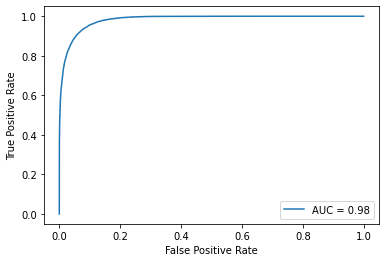

In [80]:
fpr, tpr, thresholds = roc_curve(y_test, rs_best.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot()
plt.show()

AUC of 0.98!

---  

<span style="font-size:0.5em;">Tag 5</span>

### Summary <a id='summary'></a>

<span style="font-size:0.5em;"><a href='#toc'>Back to TOC</a></span>

Show best model again:

In [81]:
rs_best.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, criterion='entropy', gamma=0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=7, max_features='auto',
                               max_samples=0.5, min_child_weight=1,
                               min_samples_split=0.38, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=16, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                      

<span style="color:blue">
    
Our metric of choice is Accuracy, and the best model found by the random search over **10** iterations had a:  

- training accuracy of **0.931**
- test accuracy was **0.931** as well
    
The best model is an **XGBoost classifier**.

Other classification metrics for context are:
- Precision/Positive Predictive Value: **0.887**
- Recall/True Positive Rate: **0.894**
- ROC AUC: **0.98**

All these metrics I would consider to be very good performance, contigent on specific use case of ultimate customer(s). For example a requirement might that the customer might want to maximize PPV as much as possible and would like to target >0.90.
    
Also, note that these results are actually a little better across the board vs our most <u>[recent neural network](./05_improved_neural_network.ipynb)</u>! But let's keep in mind the improvements in the hundredths.
    
</span>

<span style="color:blue">
Compare this to the first run, before the addition of 8 more features:
</span>

<span style="color:dodgerblue">

Was also a **XGBoost classifier**.

- training accuracy of **0.928**
- test accuracy was **0.928** as well

Other classification metrics for context are:
- Precision/Positive Predictive Value: **0.885**
- Recall/True Positive Rate: **0.885**
- ROC AUC: **0.98**
</span>

<span style="color:blue">
This run is an improvement over that as well (again we're talking about differences in the hundredths).
</span>

<span style=color:blue>    
**So is it worth it to add these features? I think on balance it is.** 
    
My reasoning is that I consider the addition of them:

- `bside`
- `pside`
- `break_x`
- `break_z`
- `angle_x`
- `angle_z`
- `pitch_speed`
        
...to be 'costless', on the assumption that whatever process captures the original features that were used in the first run also 'simultaneously' capture these additional features; so no substantial extra effort is required to gather the data.
</span>

---  

<span style="font-size:0.5em;">Tag 5</span>

#### (Re-)Tuning<a id='tuning'></a>

<span style="font-size:0.5em;"><a href='#toc'>Back to TOC</a></span>

Let's do another round of random searching, just to make sure we get decent coverage of potential parameters.

While the best classifer last round as an XGBoost classifier, on average was it the best?

In [18]:
#Declare again if picking up again after kernel restart
class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass

In [19]:
#%%script echo skipping
# Test loading pickle
load_path = './models/rs_results/classic_rs_1st_pass_20220507_1926.pickle'

with open(load_path, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    rs_results = pickle.load(f)    

In [20]:
df_rs_res = pd.DataFrame(rs_results.cv_results_)

In [21]:
df_rs_res.head(10).T

,0,1,2,3,4,5,6,7,8,9
mean_fit_time,62.453743,6.975771,117.510913,1.563657,131.90971,1.445917,0.037158,202.33841,0.039387,51.23005
std_fit_time,0.589397,0.290986,0.850715,0.028264,3.794974,0.022626,0.000812,0.727909,0.004357,1.35348
mean_score_time,0.315884,0.421356,0.319495,0.321973,0.372041,0.329985,0.0,0.479793,0.0,0.294225
std_score_time,0.09397,0.003588,0.088852,0.00125,0.045265,0.007969,0.0,0.076971,0.0,0.072109
param_clf__n_estimators,50,100,200,100,100,100,100,200,50,50
param_clf__min_samples_split,0.18,0.34,0.14,0.26,0.42,0.34,0.22,0.22,0.3,0.38
param_clf__max_samples,0.25,0.75,0.5,0.25,0.75,1,NaN,0.75,NaN,0.5
param_clf__max_features,sqrt,sqrt,log2,log2,log2,sqrt,sqrt,sqrt,auto,auto
param_clf__max_depth,8,3,4,10,9,7,3,7,5,7
param_clf__criterion,entropy,gini,gini,gini,gini,entropy,gini,entropy,entropy,entropy


Let's group by `param_clf`.

Actually, turns out that this object is actually a Classifier object, and `pandas` doesn't know how to perform `agg`s on it. So we'll need to figure out a way to get a string representing the type of classifier it is.

In [22]:
df_rs_res['type_clf'] = df_rs_res['param_clf'].apply(lambda x: type(x).__name__)

In [23]:
df_rs_res.groupby(['type_clf']).agg({'mean_test_score': 'mean'})

,mean_test_score
type_clf,
GradientBoostingClassifier,NaN
RandomForestClassifier,0.686865
XGBClassifier,0.930329


Looks like that the GBM I added might have had bad parameters. Additionally, looks like Logistic Regression never made it in. I will need to look into both.

Let's test with just the GBM grid.

In [53]:
# Create a pipeline
pipe_2 = Pipeline([('clf', DummyEstimator())]) # Placeholder Estimator

# Candidate learning algorithms and their hyperparameters
# For selected hyperparameters aimed to select a reasonable range for each.
search_space = [{'clf': [GradientBoostingClassifier()],  # Actual Estimator
                 'clf__learning_rate': [0.001, 0.01, 0.1, 0.3],
                 'clf__n_estimators': [50, 100, 200, 400],
                 'clf__max_depth': np.arange(3,11,1),
                 'clf__min_samples_split': np.linspace(0.1, 0.5, 10, endpoint=False),
                 'clf__max_features': ["auto", "sqrt", "log2"],
                }
               ]

# GradientBoostingClassifier(
# RandomForestClassifier(
    
# Create grid search 
# gs = GridSearchCV(pipe, search_space, random_state=random_state)
rs_2 = RandomizedSearchCV(pipe_2, search_space, random_state=random_state
                        ,n_iter=10 # To limit search time 
                        ,cv=2      # I like 5 as rule of thumb, but again to limit search time
                        ,verbose=True, refit=True, scoring='accuracy')

Fit the random search cv object.

In [54]:
rs_results_2 = rs_2.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


In [55]:
rs_results_2.cv_results_

{'mean_fit_time': array([ 30.53026021,  63.40619898,   9.62312722,  57.45315933,
         13.87986457,  41.52631819,  11.84277916,  37.22349918,
        250.34181857, 275.22873259]),
 'std_fit_time': array([0.4748894 , 0.06086659, 0.17480278, 0.1748364 , 0.12247169,
        0.78909934, 0.29861212, 0.47789991, 0.95397139, 8.64056563]),
 'mean_score_time': array([0.57724845, 1.12949419, 0.18323421, 1.00529218, 0.23878634,
        0.21309173, 0.22336113, 0.1950556 , 1.09769142, 0.77375615]),
 'std_score_time': array([0.00898397, 0.00578666, 0.00346708, 0.0024755 , 0.00165403,
        0.00184429, 0.00147474, 0.00047338, 0.00715911, 0.01001489]),
 'param_clf__n_estimators': masked_array(data=[200, 400, 50, 400, 100, 100, 100, 50, 400, 400],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_clf__min_samples_split': masked_array(data=[0.26, 0.26, 0.1, 0.30000000000000004,
 

Save out the results set.

In [56]:
str_ts = datetime.now(timezone.utc).astimezone(pytz.timezone('US/Pacific')).strftime("%Y%m%d_%H%M")
file_nm = 'classic_rs_2nd_pass_gbm_only' + str_ts
file_path = './models/rs_results/' + file_nm + '.pickle'
# pred_path = './predictions/test/' + file_nm + '.csv'

display(file_path)

'./models/rs_results/classic_rs_2nd_pass_gbm_only20220508_2233.pickle'

In [57]:
with open(file_path, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(rs_results_2, f, pickle.HIGHEST_PROTOCOL)

#### Review Results of GBM only

Let's review to see if GBM even approaches what XGB was achieving:

High level look at all the runs:

In [159]:
# %%script echo skipping
# Test loading pickle
load_path = './models/rs_results/classic_rs_2nd_pass_gbm_only20220508_2233.pickle'

with open(load_path, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    rs_results_2 = pickle.load(f)    

In [160]:
df_rs_gbm = pd.DataFrame(rs_results_2.cv_results_)

In [161]:
print(df_rs_gbm[['param_clf', 'mean_test_score']].head(10))

                                                                                                                                                                                          param_clf  \
0  GradientBoostingClassifier(learning_rate=0.3, max_depth=6, max_features='auto',\n                           min_samples_split=0.45999999999999996,\n                           n_estimators=400)   
1  GradientBoostingClassifier(learning_rate=0.3, max_depth=6, max_features='auto',\n                           min_samples_split=0.45999999999999996,\n                           n_estimators=400)   
2  GradientBoostingClassifier(learning_rate=0.3, max_depth=6, max_features='auto',\n                           min_samples_split=0.45999999999999996,\n                           n_estimators=400)   
3  GradientBoostingClassifier(learning_rate=0.3, max_depth=6, max_features='auto',\n                           min_samples_split=0.45999999999999996,\n                           n_estimators=400)   
4  Gr

So similar to past results it feels like there's a limit hit at around .9300

In [162]:
rs_results_2.best_estimator_

Pipeline(steps=[('clf',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=6,
                                            max_features='auto',
                                            min_samples_split=0.45999999999999996,
                                            n_estimators=400))])

Let's look at the best accuracy score, and the parameters that produced them.

In [163]:
display(rs_results_2.best_score_, rs_results_2.best_params_)

0.9295572469124045

{'clf__n_estimators': 400,
 'clf__min_samples_split': 0.45999999999999996,
 'clf__max_features': 'auto',
 'clf__max_depth': 6,
 'clf__learning_rate': 0.3,
 'clf': GradientBoostingClassifier(learning_rate=0.3, max_depth=6, max_features='auto',
                            min_samples_split=0.45999999999999996,
                            n_estimators=400)}

Let's look at it as an estimator object.

In [164]:
rs_best_2 = rs_results_2.best_estimator_
display(rs_best_2)

Pipeline(steps=[('clf',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=6,
                                            max_features='auto',
                                            min_samples_split=0.45999999999999996,
                                            n_estimators=400))])

Now let's look at performance vs Test.

In [165]:
display(f"test accuracy: {rs_best_2.score(X_test, y_test)}")
display(f"train accuracy: {rs_results_2.best_score_}")

'test accuracy: 0.5815762480054707'

'train accuracy: 0.9295572469124045'

Consistent, and aligns. That Test score is a smidge higher than train is a little weird, but isn't egregiously so, so will go with it for now.

Let's get some predictions and review some high level classification metrics:

In [64]:
rs_pred_2 = rs_best_2.predict(X_test)

*Confusion Matrix*

In [66]:
cm = confusion_matrix(y_test, rs_pred_2)
display(cm)

array([[45641,  2571],
       [ 2304, 19676]])

*Accuracy*

In [67]:
display("What % of pitches did we correctly categorize?")
display(f"test accuracy: {round(rs_best_2.score(X_test, y_test), 3)}")

'What % of pitches did we correctly categorize?'

'test accuracy: 0.931'

*Precision*

In [68]:
precision = precision_score(y_test, rs_pred_2)
display("What % predicted strikes did we get correct?")
display(f"Positive Predictive Value: {round(precision,5)}")

'What % predicted strikes did we get correct?'

'Positive Predictive Value: 0.88443'

*Recall*

In [69]:
recall = recall_score(y_test, rs_pred_2)
display("What percent of actual strikes did we get capture?")
display(f"True Positive Rate: {round(recall, 5)}")

'What percent of actual strikes did we get capture?'

'True Positive Rate: 0.89518'

*ROC/AUC*

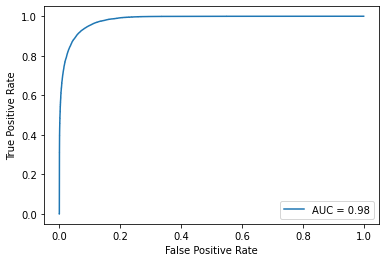

In [70]:
fpr, tpr, thresholds = roc_curve(y_test, rs_best_2.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot()
plt.show()

AUC of 0.98! Again!

So it looks like that GBM can perform just as well as XGB. Also, I think the 400 estimators is a time-killer and doesn't give much performance increase for the resource itAnd it was also apparent in previous runs that a Logistic Regression run didn't make it into the random draws. In this case I would like to do one more Random Search with the goal of:

- Increasing the iterations so that more likely to get a Logistic Regression in.
- Add back some of this GBM grid in as well.

All this said, I would be very surprised if we improve on an accuracy of ~0.930.

---  

<span style="font-size:0.5em;">Tag 5</span>

#### More Tuning<a id='more_tuning'></a>

<span style="font-size:0.5em;"><a href='#toc'>Back to TOC</a></span>

In [17]:
#Declare again if picking up again after kernel restart
class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass

In [19]:
# Create a pipeline
pipe_3 = Pipeline([('clf', DummyEstimator())]) # Placeholder Estimator

# Candidate learning algorithms and their hyperparameters
# For selected hyperparameters aimed to select a reasonable range for each.
search_space_3 = [{'clf': [LogisticRegression()], # Actual Estimator
                 'clf__penalty': ['l1', 'l2', 'elasticnet'],
                 'clf__C': np.logspace(-4, 4, 20)
                },
                {'clf': [DecisionTreeClassifier()],  # Actual Estimator
                 'clf__criterion': ['gini', 'entropy'],
                 'clf__max_depth': np.arange(3,11,1),
                 'clf__min_samples_split': np.linspace(0.1, 0.5, 10, endpoint=False),
                 'clf__max_features': [0.25, 0.5, 0.75, 1]
                },
                {'clf': [RandomForestClassifier()],  # Actual Estimator
                 'clf__n_estimators': [50, 100, 200],
                 'clf__criterion': ['gini', 'entropy'],                 
                 'clf__max_depth': np.arange(3,11,1),
                 'clf__min_samples_split': np.linspace(0.1, 0.5, 10, endpoint=False),
                 'clf__max_features': ["auto", "sqrt", "log2"],
                 'clf__max_samples': [0.25, 0.5, 0.75, 1]
                },
                 {'clf': [GradientBoostingClassifier()],  # Actual Estimator
                 'clf__learning_rate': [0.001, 0.01, 0.1, 0.3],
                 'clf__n_estimators': [50, 100, 200],
                 'clf__max_depth': np.arange(3,11,1),
                 'clf__min_samples_split': np.linspace(0.1, 0.5, 10, endpoint=False),
                 'clf__max_features': ["auto", "sqrt", "log2"],
                },
                {'clf': [XGBClassifier()],  # Actual Estimator
                 'clf__n_estimators': [50, 100, 200],
                 'clf__criterion': ['gini', 'entropy'],                 
                 'clf__max_depth': np.arange(3,11,1),
                 'clf__min_samples_split': np.linspace(0.1, 0.5, 10, endpoint=False),
                 'clf__max_features': ["auto", "sqrt", "log2"],
                 'clf__max_samples': [0.25, 0.5, 0.75, 1]
                }
               ]
    
# Create grid search 
# gs = GridSearchCV(pipe, search_space, random_state=random_state)
rs_3 = RandomizedSearchCV(pipe_3, search_space_3, random_state=random_state
                        ,n_iter=20 # To limit search time 
                        ,cv=3      # I like 5 as rule of thumb, but again to limit search time
                        ,verbose=True, refit=True, scoring='accuracy')

Fit the random search cv object.

In [20]:
rs_results_3 = rs_3.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[13:54:20] WARNING: ../src/learner.cc:541: 
Parameters: { criterion, max_features, max_samples, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:54:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:54:57] WARNING: ../src/learner.cc:541: 
Parameters: { criterion, max_features, max_samples, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
 

Save out the results set.

In [ ]:
str_ts = datetime.now(timezone.utc).astimezone(pytz.timezone('US/Pacific')).strftime("%Y%m%d_%H%M")
file_nm = 'classic_rs_3rd_pass_' + str_ts
file_path = './models/rs_results/' + file_nm + '.pickle'
# pred_path = './predictions/test/' + file_nm + '.csv'

display(file_path)

'./models/rs_results/classic_rs_3rd_pass_20220509_0815.pickle'

In [ ]:
with open(file_path, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(rs_results_3, f, pickle.HIGHEST_PROTOCOL)

*_Reload results as necessary_*

In [155]:
#%%script echo skipping
# Test loading pickle
load_path = './models/rs_results/classic_rs_3rd_pass_20220509_0815.pickle'

with open(load_path, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    rs_results_3 = pickle.load(f)    

#### Review Results

Let's review the best model of the random selected models. Load from pickle if necessary.

Third time's the charm?

In [20]:
rs_results_3.best_estimator_

Pipeline(steps=[('clf',
                 GradientBoostingClassifier(max_depth=10, max_features='auto',
                                            min_samples_split=0.14,
                                            n_estimators=200))])

In [22]:
rs_results_3.best_params_

{'clf__n_estimators': 200,
 'clf__min_samples_split': 0.14,
 'clf__max_features': 'auto',
 'clf__max_depth': 10,
 'clf__learning_rate': 0.1,
 'clf': GradientBoostingClassifier(max_depth=10, max_features='auto',
                            min_samples_split=0.14, n_estimators=200)}

In [23]:
rs_results_3.best_score_

0.9311671243415359

In [24]:
rs_results_3.cv_results_

{'mean_fit_time': array([ 34.36048587,   7.76753036, 144.09038631, 335.16320491,
          1.65007035,  92.10491292,   1.51282962,  17.71212244,
        103.43485896,  37.27409482, 269.6652774 ,  33.02737451,
         79.72879394, 132.05992174, 129.32118686,   3.28230333,
          1.54987295,   3.41883659,   1.54029504,  22.22682412]),
 'std_fit_time': array([ 2.66895962,  0.24492797,  3.41328736,  2.00402526,  0.01978322,
         8.5013215 ,  0.02172415,  0.03579268,  6.79503714,  0.69397237,
        10.46101827,  8.9632727 ,  4.82333111,  3.20010087,  0.18563859,
         0.02522395,  0.04011796,  0.11855185,  0.02261624,  0.19565816]),
 'mean_score_time': array([0.16867129, 0.43467633, 0.3042647 , 0.51615429, 0.33026203,
        0.26266829, 0.33306082, 0.15117311, 0.32010365, 0.09233665,
        0.53464174, 0.13813019, 0.33402236, 0.34228881, 0.30139359,
        0.64917278, 0.32982095, 0.40859993, 0.33224583, 1.01383074]),
 'std_score_time': array([0.0425603 , 0.00212381, 0.027189

Convert `.cv_results_` to `DataFrame` for better readability

In [25]:
df_rs_res_3 = pd.DataFrame(rs_results_3.cv_results_)

In [26]:
df_rs_res_3.shape

(20, 19)

In [27]:
df_rs_res_3.head(10).T

,0,1,2,3,4,5,6,7,8,9
mean_fit_time,34.360486,7.76753,144.090386,335.163205,1.65007,92.104913,1.51283,17.712122,103.434859,37.274095
std_fit_time,2.66896,0.244928,3.413287,2.004025,0.019783,8.501322,0.021724,0.035793,6.795037,0.693972
mean_score_time,0.168671,0.434676,0.304265,0.516154,0.330262,0.262668,0.333061,0.151173,0.320104,0.092337
std_score_time,0.04256,0.002124,0.027189,0.012375,0.004067,0.09122,0.01039,0.001663,0.052218,0.001142
param_clf__n_estimators,50,100,100,200,100,100,100,100,200,50
param_clf__min_samples_split,0.18,0.34,0.46,0.14,0.26,0.42,0.34,0.22,0.22,0.3
param_clf__max_samples,0.25,0.75,0.25,NaN,0.25,0.75,1,NaN,0.75,NaN
param_clf__max_features,sqrt,sqrt,sqrt,auto,log2,log2,sqrt,sqrt,sqrt,auto
param_clf__max_depth,4,3,9,10,10,5,7,3,3,5
param_clf__criterion,entropy,gini,entropy,NaN,gini,gini,entropy,NaN,entropy,NaN


Let's view performance via `accuracy` across the models. 

Now let's look at performance vs Test.

Create `model_type` column

In [29]:
df_rs_res_3['model_type'] = df_rs_res_3['param_clf'].apply(lambda x : type(x).__name__)

Look at spread of model's randomly chosen:

In [31]:
df_rs_res_3['model_type'].value_counts(ascending=False)

RandomForestClassifier        8
XGBClassifier                 8
GradientBoostingClassifier    4
Name: model_type, dtype: int64

Again `LogisticRegression` didn't get randomly chosen; I will just do a quick RV on `LogisticRegression` for due diligence after reviewing this set.

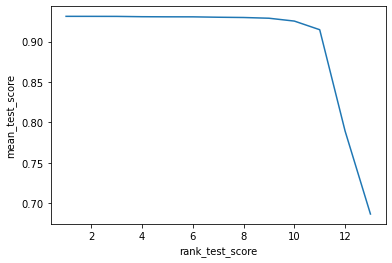

In [33]:
sns.lineplot(x='rank_test_score', y='mean_test_score', data=df_rs_res_3)
plt.show()

It appears most models performed around that .930 range, with the rest in the .68ish range.

let's take a quick look at similarly performing models, and see if we can glean anything from their different in parameters.

In [56]:
# Increase column widths
pd.set_option('display.max_colwidth', 200)

df_rs_res_3[['rank_test_score', 'mean_test_score', 'model_type', 'params']].sort_values(by='rank_test_score', ascending=True)

,rank_test_score,mean_test_score,model_type,params
3,1,0.931167,GradientBoostingClassifier,"{'clf__n_estimators': 200, 'clf__min_samples_split': 0.14, 'clf__max_features': 'auto', 'clf__max_depth': 10, 'clf__learning_rate': 0.1, 'clf': GradientBoostingClassifier(max_depth=10, max_feature..."
8,2,0.931146,XGBClassifier,"{'clf__n_estimators': 200, 'clf__min_samples_split': 0.22, 'clf__max_samples': 0.75, 'clf__max_features': 'sqrt', 'clf__max_depth': 3, 'clf__criterion': 'entropy', 'clf': XGBClassifier(base_score=..."
5,3,0.931096,XGBClassifier,"{'clf__n_estimators': 100, 'clf__min_samples_split': 0.42000000000000004, 'clf__max_samples': 0.75, 'clf__max_features': 'log2', 'clf__max_depth': 5, 'clf__criterion': 'gini', 'clf': XGBClassifier..."
13,4,0.930701,XGBClassifier,"{'clf__n_estimators': 100, 'clf__min_samples_split': 0.22, 'clf__max_samples': 0.75, 'clf__max_features': 'log2', 'clf__max_depth': 7, 'clf__criterion': 'gini', 'clf': XGBClassifier(base_score=Non..."
0,5,0.930576,XGBClassifier,"{'clf__n_estimators': 50, 'clf__min_samples_split': 0.18, 'clf__max_samples': 0.25, 'clf__max_features': 'sqrt', 'clf__max_depth': 4, 'clf__criterion': 'entropy', 'clf': XGBClassifier(base_score=N..."
12,6,0.930540,XGBClassifier,"{'clf__n_estimators': 50, 'clf__min_samples_split': 0.14, 'clf__max_samples': 0.75, 'clf__max_features': 'sqrt', 'clf__max_depth': 9, 'clf__criterion': 'entropy', 'clf': XGBClassifier(base_score=N..."
11,7,0.930056,XGBClassifier,"{'clf__n_estimators': 50, 'clf__min_samples_split': 0.38, 'clf__max_samples': 0.5, 'clf__max_features': 'auto', 'clf__max_depth': 3, 'clf__criterion': 'entropy', 'clf': XGBClassifier(base_score=No..."
2,8,0.929732,XGBClassifier,"{'clf__n_estimators': 100, 'clf__min_samples_split': 0.45999999999999996, 'clf__max_samples': 0.25, 'clf__max_features': 'sqrt', 'clf__max_depth': 9, 'clf__criterion': 'entropy', 'clf': XGBClassif..."
10,9,0.928827,XGBClassifier,"{'clf__n_estimators': 200, 'clf__min_samples_split': 0.33999999999999997, 'clf__max_samples': 0.75, 'clf__max_features': 'log2', 'clf__max_depth': 8, 'clf__criterion': 'entropy', 'clf': XGBClassif..."
14,10,0.925305,GradientBoostingClassifier,"{'clf__n_estimators': 200, 'clf__min_samples_split': 0.38, 'clf__max_features': 'auto', 'clf__max_depth': 7, 'clf__learning_rate': 0.01, 'clf': GradientBoostingClassifier(max_depth=10, max_feature..."


**Observations:**  
- `XGBoost` performs consisently above the others, which is to be expected. In real world it tends to do that as well :)
- Ranging peformance for `GBM`, whicn on quick parsing it seems to align with increasing `max_depth`.
- Random Forest lags and odd that they all perform 'the same' even across wide gaps of `max_depth` (e.g. Model index 18 performed the same as Model index 4 but have max depth's of 3, and 10, respectively.



**Let's zero in on the best model in more detail.**

In [51]:
rs_best_3 = rs_results_3.best_estimator_

In [57]:
y_pred = rs_best_3.predict(X_train)

In [55]:
display(f"test accuracy: {rs_best_3.score(X_test, y_test)}")
display(f"train accuracy: {rs_results_3.best_score_}")

'test accuracy: 0.5719455208570777'

'train accuracy: 0.9311671243415359'

Hmmmm, could be some egregious overfitting.

In [69]:
rs_results_3.best_params_

{'clf__n_estimators': 200,
 'clf__min_samples_split': 0.14,
 'clf__max_features': 'auto',
 'clf__max_depth': 10,
 'clf__learning_rate': 0.1,
 'clf': GradientBoostingClassifier(max_depth=10, max_features='auto',
                            min_samples_split=0.14, n_estimators=200)}

In [70]:
gb_clf = GradientBoostingClassifier(max_depth=10, max_features='auto'
                                    ,min_samples_split=0.14
                                    ,n_estimators=200
                                    ,learning_rate=0.1
                                    ,random_state=random_state)

Well, at a max_depth of 10 and 200 trees and learning rate of 0.1, maybe it really did overfit.

**Let's look at the runner-up model.**

Get `clf` for runner-up.

In [124]:
rank_seek = 2
pd.json_normalize(df_rs_res_3.loc[df_rs_res_3['rank_test_score']==rank_seek][['params']]['params']).T

,0
clf__n_estimators,200
clf__min_samples_split,0.22
clf__max_samples,0.75
clf__max_features,sqrt
clf__max_depth,3
clf__criterion,entropy
clf,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', in..."


In [130]:
xgb_cf = XGBClassifier(n_estimators=200, min_samples_split=0.22, max_samples=0.75, max_features='sqrt', max_depth=3, criterion='entropy', random_state=random_state)

In [131]:
xgb_cv = cross_val_score(xgb_cf, X_train, y_train, cv=3)

[16:44:53] WARNING: ../src/learner.cc:541: 
Parameters: { criterion, max_features, max_samples, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:44:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:46:55] WARNING: ../src/learner.cc:541: 
Parameters: { criterion, max_features, max_samples, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


In [132]:
xgb_cv

array([0.93109233, 0.93186165, 0.93026958])

Looks stable.

Let's fit and look at performance vs test.

In [133]:
xgb_cf.fit(X_train, y_train)

[16:53:02] WARNING: ../src/learner.cc:541: 
Parameters: { criterion, max_features, max_samples, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:53:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, criterion='entropy',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, max_features='sqrt',
              max_samples=0.75, min_child_weight=1, min_samples_split=0.22,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=16, num_parallel_tree=1, random_state=24, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [151]:
xgb_cf.score(X_train, y_train)

0.9339238585731229

In [152]:
display(f"test accuracy: {rs_best_3.score(X_test, y_test)}")
display(f"train accuracy: {rs_results_3.best_score_}")

'test accuracy: 0.5719455208570777'

'train accuracy: 0.9311671243415359'

Overfitting again? Didn't really see this in previous runs. Let's retrieve the results of the first RV run of this notebook.

In [156]:
#%%script echo skipping
# Test loading pickle
load_path = './models/rs_results/classic_rs_2nd_pass_20220507_1926.pickle'

with open(load_path, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    rs_results_orig = pickle.load(f)    

Check test scores on the best estimator.

In [157]:
rs_best_orig = rs_results_orig.best_estimator_

In [158]:
rs_best_orig.score(X_test, y_test)

0.6659305903806702

Consistent, and aligns. That Test score is a smidge higher than train is a little weird, but isn't egregiously so, so will go with it for now.

Let's get some predictions and review some high level classification metrics:

In [74]:
rs_pred = rs_best.predict(X_test)

*Confusion Matrix*

In [75]:
from sklearn.metrics import (confusion_matrix, precision_score, recall_score
                             ,plot_roc_curve
                            )

In [76]:
cm = confusion_matrix(y_test, rs_pred)
display(cm)

array([[45709,  2503],
       [ 2323, 19657]])

*Accuracy*

In [77]:
display("What % of pitches did we correctly categorize?")
display(f"test accuracy: {round(rs_best.score(X_test, y_test), 3)}")

'What % of pitches did we correctly categorize?'

'test accuracy: 0.931'

*Precision*

In [78]:
precision = precision_score(y_test, rs_pred)
display("What % predicted strikes did we get correct?")
display(f"Positive Predictive Value: {round(precision,5)}")

'What % predicted strikes did we get correct?'

'Positive Predictive Value: 0.88705'

*Recall*

In [79]:
recall = recall_score(y_test, rs_pred)
display("What percent of actual strikes did we get capture?")
display(f"True Positive Rate: {round(recall, 5)}")

'What percent of actual strikes did we get capture?'

'True Positive Rate: 0.89431'

*ROC/AUC*

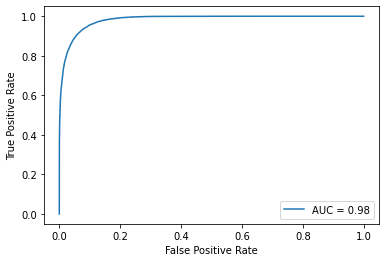

In [80]:
fpr, tpr, thresholds = roc_curve(y_test, rs_best.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot()
plt.show()

AUC of 0.98!

In [118]:
np.linspace(0.1, 0.5, 5, endpoint=True)

array([0.1, 0.2, 0.3, 0.4, 0.5])

In [108]:
np.arange(3,11,1)

array([ 3,  4,  5,  6,  7,  8,  9, 10])

In [17]:
# Create a pipeline
pipe_2 = Pipeline([('clf', DummyEstimator())]) # Placeholder Estimator

# Candidate learning algorithms and their hyperparameters
# For selected hyperparameters aimed to select a reasonable range for each.
search_space = [
                {'clf': [XGBClassifier()],  # Actual Estimator
                 'clf__n_estimators': [50, 100, 200],
                 'clf__criterion': ['gini', 'entropy'],                 
                 'clf__max_depth': np.arange(3,11,1),
                 'clf__min_samples_split': np.linspace(0.1, 0.5, 10, endpoint=False),
                 'clf__max_features': ["auto", "sqrt", "log2"],
                 'clf__max_samples': [0.25, 0.5, 0.75, 1]
                }
               ]


# GradientBoostingClassifier(
# RandomForestClassifier(
    
# Create grid search 
# gs = GridSearchCV(pipe, search_space, random_state=random_state)
rs = RandomizedSearchCV(pipe, search_space, random_state=random_state
                        ,n_iter=10 # To limit search time 
                        ,cv=3      # I like 5 as rule of thumb, but again to limit search time
                        ,verbose=True, refit=True, scoring='accuracy')

---  

<span style="font-size:0.5em;">Tag 5</span>

<a id='the_end'></a>

<span style="font-size:0.5em;"><a href='#toc'>Back to TOC</a></span>

In [83]:
rs_best.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, criterion='entropy', gamma=0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=7, max_features='auto',
                               max_samples=0.5, min_child_weight=1,
                               min_samples_split=0.38, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=16, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                      

In [92]:
rs_best.named_steps["clf"]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, criterion='entropy',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=7, max_features='auto',
              max_samples=0.5, min_child_weight=1, min_samples_split=0.38,
              missing=nan, monotone_constraints='()', n_estimators=50,
              n_jobs=16, num_parallel_tree=1, random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [93]:
type(rs)

sklearn.model_selection._search.RandomizedSearchCV

In [94]:
rs.best_estimator_

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, criterion='entropy', gamma=0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=7, max_features='auto',
                               max_samples=0.5, min_child_weight=1,
                               min_samples_split=0.38, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=16, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbo

In [99]:
z = rs.best_estimator_.named_steps["clf"]

In [105]:
X_train.shape

(280767, 13)

In [106]:
z.get_booster().get_fscore()

{'f2': 580,
 'f5': 672,
 'f1': 152,
 'f3': 322,
 'f9': 57,
 'f8': 160,
 'f4': 375,
 'f7': 260,
 'f0': 298,
 'f6': 255,
 'f11': 10}

In [107]:
df_X.columns

Index(['break_x', 'stringer_zone_bottom', 'pz', 'angle_z', 'angle_x', 'px',
       'break_z', 'pitch_speed', 'stringer_zone_top', 'bside_L', 'bside_R',
       'pside_L', 'pside_R'],
      dtype='object')

In [103]:
len(z.get_booster().get_fscore())

11

In [102]:
X_train.shape

(280767, 13)

In [87]:
rs_best.named_steps["clf"].get_score()

AttributeError: 'XGBClassifier' object has no attribute 'get_score'

-----